# Dependance of Rayleigh wrt airmass and compare libradtran and pyextinction

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2024/11/25
- last update : 2024/12/03

This comparison between getObsAtmo and pyExtinction is done only if libradtranpy is installed

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Imports

In [3]:
import copy
import astropy.io.fits as F

In [4]:
from getObsAtmo.getObsAtmo import ObsAtmo,validateObsName,Dict_Of_sitesPressures,getObsSiteDataFrame

In [5]:
from pyextinction.AtmosphericExtinction import ExtinctionModel,EXT2OPT

## Do thing with pyExtinction

In [6]:
def readOzoneTemplatexy(ozoneName,
                      colLbda='LAMBDA', colTrans='OZONE', ext=1):
    """
    Read ozone transmission template, interpolate over
    wavelengthes, and convert to extinction [mag/airmass].

    :param ozoneName: input FITS table, with columns *colLbda*
      (wavelength in AA) and *colTrans* (fractional transmission), and
      key 'REFO3COL' specifing the reference ozone column density [DU]
    :param lbda: output wavelengthes [AA]
    :param colLbda: name of the wavelength (in AA) column
    :param colTrans: name of the ozone transmission column
    :param ext: extension in which to look for wavelength and
      transmission columns
    :return: ozone extinction [mag/airmass], refO3col
    """

    # Read wavelength and transmission columns
    ffile = F.open(ozoneName)
    x = ffile[ext].data.field(colLbda)   # Wavelength
    y = ffile[ext].data.field(colTrans)  # Transmission
    refO3col = ffile[ext].header["REFO3COL"]
    return x,y,refO3col


In [7]:
# Default ozone template
#pyE_O3Template = os.path.join(os.path.dirname(os.path.abspath(__file__)),'o3data/ozoneTemplate.fits')
pyE_O3Template = '/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/libradtranpy/src/pyextinction/o3data/ozoneTemplate.fits'

# Check information

In [8]:
Dict_Of_sitesPressures

{'LSST': 731.50433,
 'CTIO': 774.6052,
 'OHP': 937.22595,
 'PDM': 710.90637,
 'OMK': 600.17224,
 'OSL': 1013.0}

### Choose Rubin-LSST observation sites but other sites may be chosen

In [9]:
obssitename = 'LSST'
obs_str = validateObsName(obssitename) 
std_pressure = Dict_Of_sitesPressures[obs_str]

In [10]:
emul =  ObsAtmo(obs_str= obssitename)

LSST site name validated as LSST observatory


# Typical transmission plot

- show a typical transmission plot

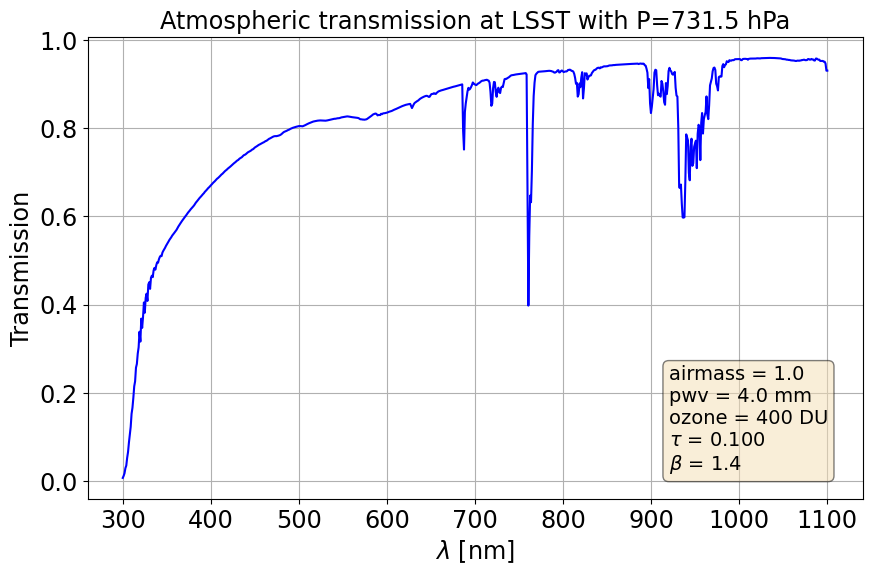

In [11]:
emul.plot_transmission()

# Setting atmospheric parameters

In [12]:
WL = emul.GetWL()
airmasses = emul.AIRMASS
NAM = len(airmasses)
pwvs = emul.PWV
NPWV = len(pwvs)
ozs = emul.OZ
NOZ = len(ozs)

In [13]:
airmasses

array([1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.3 ,
       1.4 , 1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 2.  , 2.1 , 2.2 , 2.3 , 2.4 ,
       2.5 ])

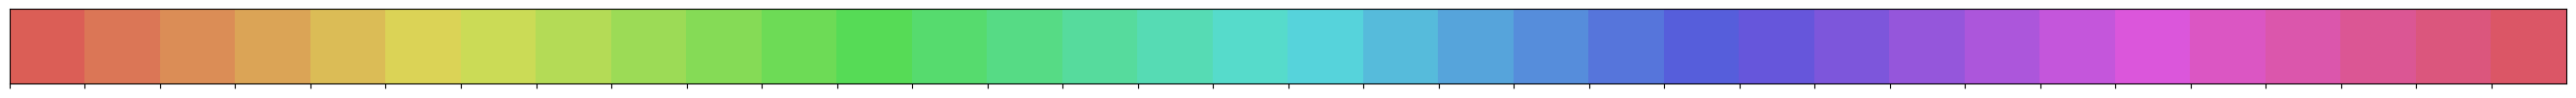

In [14]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

## Rayleigh scattering with pyExtinction

In [15]:
#pyE_press = 731.50433
pyE_press = 675.0
pyE_o3 = 300.
pyE_tau = 0.0
pyE_ang = 1
pyE_pars = np.array([pyE_press,pyE_o3,pyE_tau,pyE_ang])

In [16]:
label1='Rayleigh [%.0f mbar]' % pyE_press
label2='Ozone [%.0f DU]' % pyE_o3
label3=u'Aerosols [τ=%.4f, å=%.2f]' % (pyE_tau, pyE_ang)
all_labels = [label1,label2,label3]

In [17]:
pyExt_model = ExtinctionModel(WL*10.)

In [18]:
pyExt_model.setParams(pyE_pars, dpars=None)
pyE_components_extinctions = pyExt_model.extinctionComponents()
pyE_opticalindexes = EXT2OPT * pyE_components_extinctions
pyE_xO3ref,pyE_yO3ref,pyE_refO3col = readOzoneTemplatexy(pyE_O3Template)

In [19]:
rayleigh_extinction = pyE_components_extinctions[0,:]
ozone_extinction = pyE_components_extinctions[1,:]
aerosol_extinction = pyE_components_extinctions[2,:]
rayleigh_opticalindex = EXT2OPT * rayleigh_extinction 
ozone_opticalindex = EXT2OPT * ozone_extinction 
aerosol_opticalindex = EXT2OPT * aerosol_extinction 
all_optical_indexes = [rayleigh_opticalindex,ozone_opticalindex ,aerosol_opticalindex]

In [20]:
ncomp = pyE_components_extinctions.shape[0]

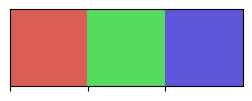

In [21]:
hls_colors = sns.color_palette("hls", ncomp)
sns.palplot(hls_colors)

Text(0.5, 0, '$\\lambda$ (nm)')

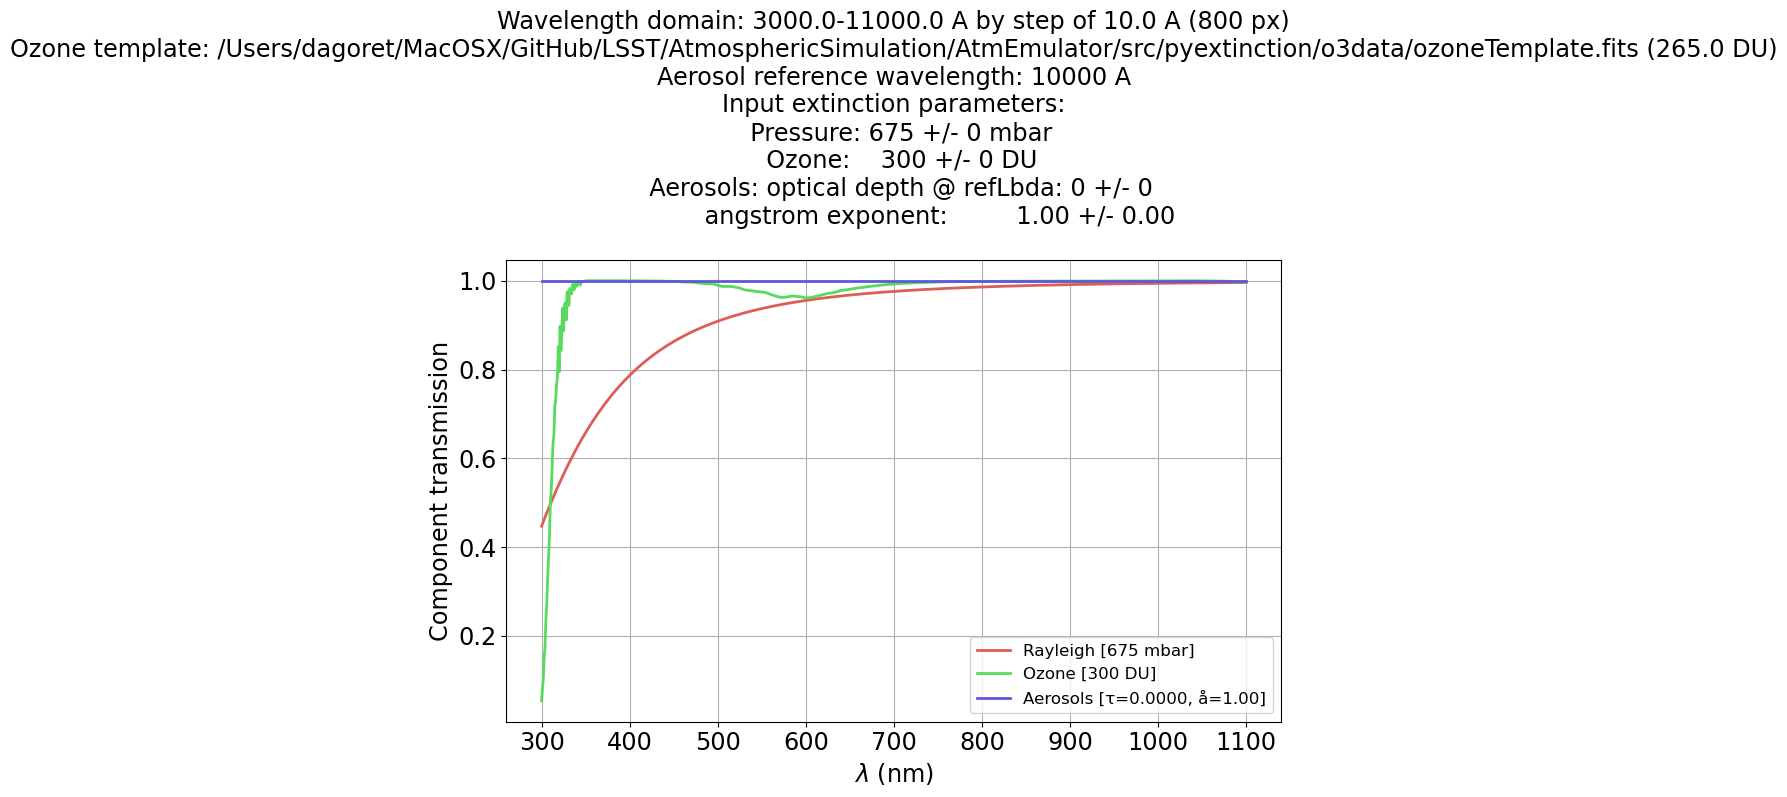

In [22]:
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot()

for idx in range(ncomp):
    ax.plot(WL,np.exp(-all_optical_indexes[idx]),color=hls_colors[idx],label=all_labels[idx],lw=2) 

ax.grid()


#ax.plot(xozref/10,yozref,color="k",label=labeloz_ref)
ax.legend()
ax.set_title(pyExt_model.__str__())
ax.set_ylabel("Component transmission")
ax.set_xlabel("$\\lambda$ (nm)")


## Check emulator with Rayleigh scattering

    @staticmethod
        def rayleigh_HT74(lbda, pressure):
            """
            Rayleigh extinction from `Hansen & Travis (1974)
            <http://cdsads.u-strasbg.fr/abs/1974SSRv...16..527H>`_.

            :param lbda: wavelength vector [AA]
            :param pressure: effective surface pressure [mbar]
            :return: Rayleigh extinction [mag/airmass]
            """

            lm = lbda * 1e-4                # Wavelength from A to microns

            # Optical depth
            tau = 0.008569 / lm**4 * (1 + 0.0113 / lm**2 + 0.00013 / lm**4)
            tau *= pressure / 1013.25

            return tau / EXT2OPT    # Convert to attenuation [mag/airmass]

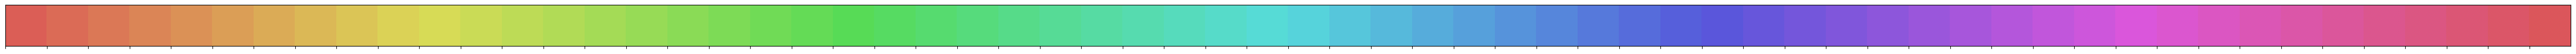

In [23]:
hls_colors = sns.color_palette("hls", NPWV)
sns.palplot(hls_colors)

In [24]:
WLtest = np.arange(350,1000,100)

In [25]:
WLtest

array([350, 450, 550, 650, 750, 850, 950])

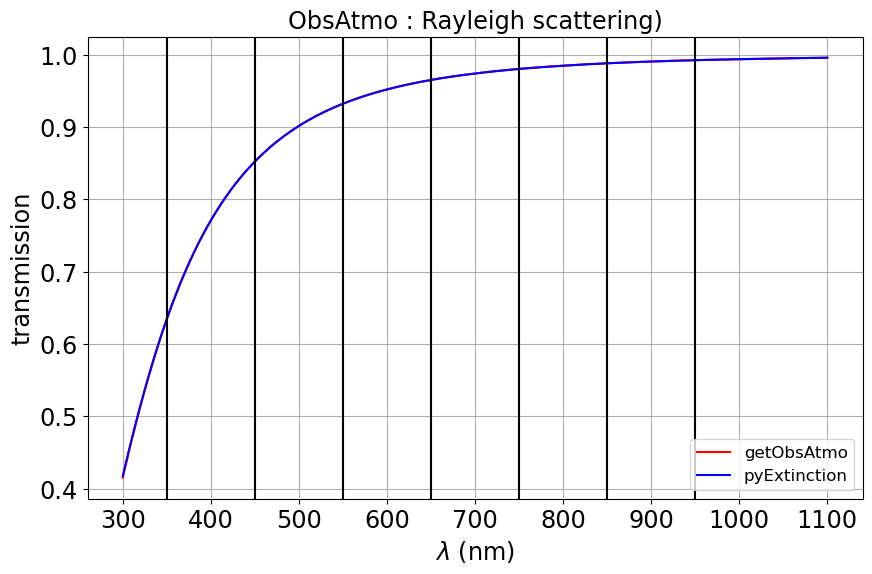

In [26]:
am =1

fig, ax = plt.subplots()

transm = emul.GetRayleighTransparencyArray(WL,am)
  
  
ax.plot(WL,transm,"-",color="r",label="getObsAtmo")
ax.plot(WL,np.exp(-rayleigh_extinction),'-',color="b",label="pyExtinction")
        
title = f"ObsAtmo : Rayleigh scattering)"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
#ax.set_xlim(680.,780.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

for wl in WLtest:
    ax.axvline(wl,color="k")

plt.show()

## Dependence with airmass

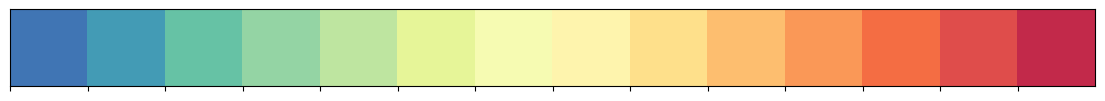

In [27]:
WLtest = np.arange(350,1050,50)
NWLtest = len(WLtest)
hls_colors = sns.color_palette("Spectral_r", NWLtest)
#hls_colors = sns.color_palette("coolwarm",NWLtest)
#sns.palplot(hls_colors)
sns.palplot(hls_colors)

In [28]:
binnumber = np.digitize(WLtest,WLtest)
binnumber

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [29]:
linestyles = ["-","--","-.",":",  "-","--","-.",":"]
linewidths = [4,4,4,4,2,2,2,2]

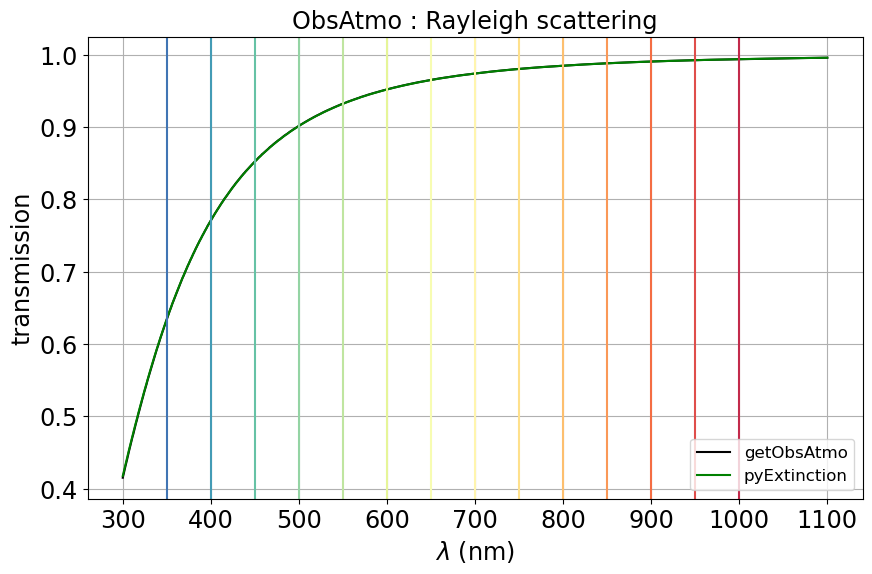

In [30]:
am =1

fig, ax = plt.subplots()

transm = emul.GetRayleighTransparencyArray(WL,am)

ax.plot(WL,transm,"-",color="k",label="getObsAtmo")
ax.plot(WL,np.exp(-rayleigh_extinction),'-',color="g",label="pyExtinction")
        
title = f"ObsAtmo : Rayleigh scattering"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
#ax.set_xlim(680.,780.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)

for idx,wl in enumerate(WLtest):
    ax.axvline(wl,color=hls_colors[idx])

ax.grid()
ax.legend()


## pyExtinction with WLtest

In [31]:
#pyE_press = 731.50433
#pyE_press = 680.0
pyE_o3 = 300.
pyE_tau = 0.0
pyE_ang = 1
pyE_pars = np.array([pyE_press,pyE_o3,pyE_tau,pyE_ang])

In [32]:
pyExt_model = ExtinctionModel(WLtest*10.)
pyExt_model.setParams(pyE_pars, dpars=None)
pyE_components_extinctions = pyExt_model.extinctionComponents()
pyE_opticalindexes = EXT2OPT * pyE_components_extinctions

In [33]:
rayleigh_extinction = pyE_components_extinctions[0,:]
#ozone_extinction = pyE_components_extinctions[1,:]
#aerosol_extinction = pyE_components_extinctions[2,:]
rayleigh_opticalindex = EXT2OPT * rayleigh_extinction 

## Plot

Text(0.5, 1.0, 'Rayleigh scatt transmission vs $airmass$')

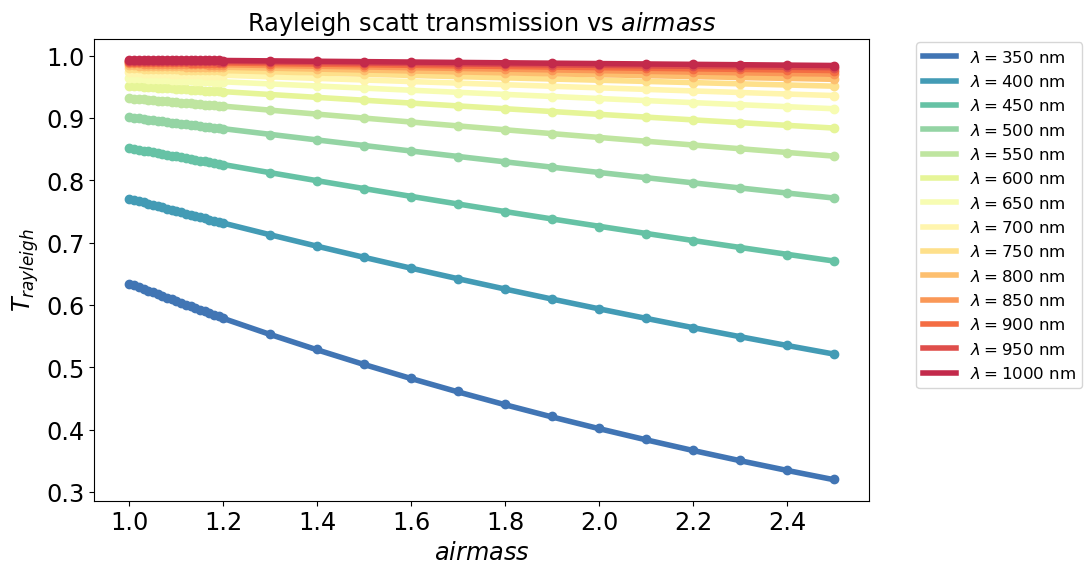

In [34]:
fig,ax = plt.subplots(1,1)

# compute a new transmission array in airmass x wl
transmarray = np.zeros((NAM,NWLtest))
    
for idx_am,airmass in enumerate(airmasses):
    transmarray[idx_am,:]  = emul.GetRayleighTransparencyArray(WLtest,airmass)
    # normalize wrt airmass = 1 for each wavelength
    #norm_am0 = np.copy(transmarray[0,:])
    
    # renormalize to first airmass
    #for idx_am,airmass in enumerate(airmasses):
    #    transmarray[idx_am,:] =  transmarray[idx_am,:]/norm_am0

    # plot attenuation 
for idx_wl,wl in enumerate(WLtest):
    x = airmasses
    y = transmarray[:,idx_wl]

    y_pyE = np.exp(-rayleigh_extinction[idx_wl]*x)
        
    bin_number_for_wl = np.digitize(wl,WLtest)-1
    the_wl_color = hls_colors[bin_number_for_wl]
    ls = linestyles[0]
    lw = linewidths[0]

    
    label = "$\\lambda = $" + f"{wl:.0f} nm"
    ax.plot(x,y,color=the_wl_color,ls = ls,lw=lw,label=label)
    ax.plot(x,y_pyE,color=the_wl_color,lw=0,marker="o")
        
#ax.legend(loc='upper right')
ax.legend(bbox_to_anchor=(1.05, 1.01))
ax.set_xlabel("$airmass$")  
ax.set_ylabel("$T_{rayleigh}$")  
ax.set_title("Rayleigh scatt transmission vs $airmass$")

Text(0.5, 1.0, 'Rayleigh scatt extinction vs $airmass$')

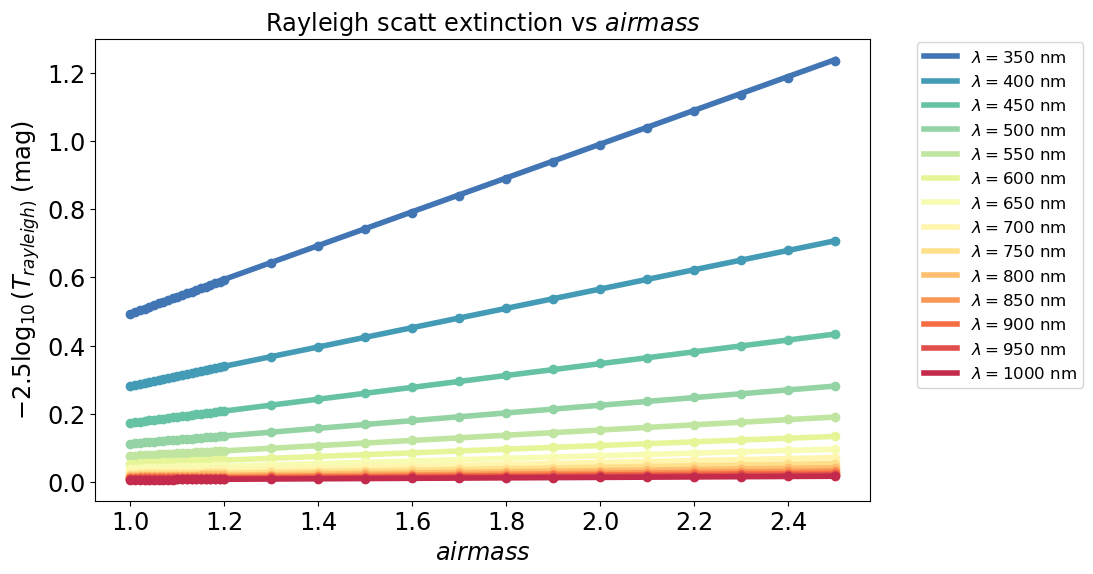

In [35]:
fig,ax = plt.subplots(1,1)

# compute a new transmission array in airmass x wl
transmarray = np.zeros((NAM,NWLtest))
    
for idx_am,airmass in enumerate(airmasses):
    transmarray[idx_am,:]  = emul.GetRayleighTransparencyArray(WLtest,airmass)
    # normalize wrt airmass = 1 for each wavelength
    #norm_am0 = np.copy(transmarray[0,:])
    
    # renormalize to first airmass
    #for idx_am,airmass in enumerate(airmasses):
    #    transmarray[idx_am,:] =  transmarray[idx_am,:]/norm_am0

    # plot attenuation 
for idx_wl,wl in enumerate(WLtest):
    x = airmasses
    y = -2.5*np.log10(transmarray[:,idx_wl])
    y_pyE = -2.5*np.log10(np.exp(-rayleigh_extinction[idx_wl]*x))
        
    bin_number_for_wl = np.digitize(wl,WLtest)-1
    the_wl_color = hls_colors[bin_number_for_wl]
    ls = linestyles[0]
    lw = linewidths[0]

    
    label = "$\\lambda = $" + f"{wl:.0f} nm"
    ax.plot(x,y,color=the_wl_color,ls = ls,lw=lw,label=label)
    ax.plot(x,y_pyE,color=the_wl_color,lw=0,marker="o")
        
#ax.legend(loc='upper right')
ax.legend(bbox_to_anchor=(1.05, 1.01))
ax.set_xlabel("$airmass$")  
ax.set_ylabel("$-2.5\\log_{10}(T_{rayleigh)}$ (mag)")  
ax.set_title("Rayleigh scatt extinction vs $airmass$")

Text(0.5, 1.0, 'Rayleigh scatt extinction vs $airmass$')

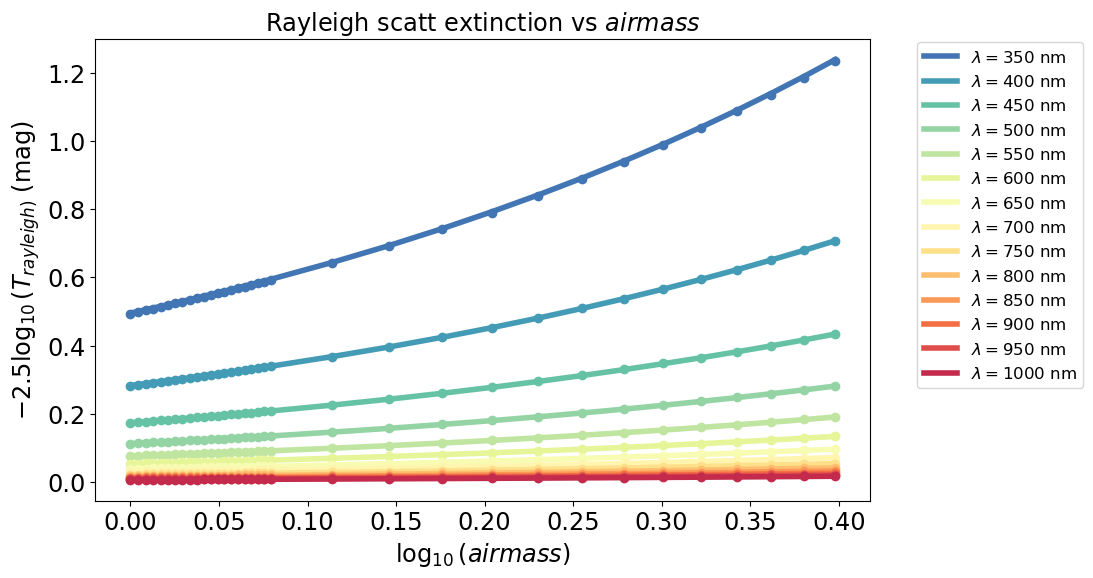

In [36]:
fig,ax = plt.subplots(1,1)

# compute a new transmission array in airmass x wl
transmarray = np.zeros((NAM,NWLtest))
    
for idx_am,airmass in enumerate(airmasses):
    transmarray[idx_am,:]  = emul.GetRayleighTransparencyArray(WLtest,airmass)
    # normalize wrt airmass = 1 for each wavelength
    #norm_am0 = np.copy(transmarray[0,:])
    
    # renormalize to first airmass
    #for idx_am,airmass in enumerate(airmasses):
    #    transmarray[idx_am,:] =  transmarray[idx_am,:]/norm_am0

    # plot attenuation 
for idx_wl,wl in enumerate(WLtest):
    x = np.log10(airmasses)
    y = -2.5*np.log10(transmarray[:,idx_wl])
    y_pyE = -2.5*np.log10(np.exp(-rayleigh_extinction[idx_wl]*airmasses))
        
    bin_number_for_wl = np.digitize(wl,WLtest)-1
    the_wl_color = hls_colors[bin_number_for_wl]
    ls = linestyles[0]
    lw = linewidths[0]

    
    label = "$\\lambda = $" + f"{wl:.0f} nm"
    ax.plot(x,y,color=the_wl_color,ls = ls,lw=lw,label=label)
    ax.plot(x,y_pyE,color=the_wl_color,lw=0,marker="o")
        
#ax.legend(loc='upper right')
ax.legend(bbox_to_anchor=(1.05, 1.01))
ax.set_xlabel("$\\log_{10}(airmass)$")  
ax.set_ylabel("$-2.5\\log_{10}(T_{rayleigh)}$ (mag)")  
ax.set_title("Rayleigh scatt extinction vs $airmass$")

## Fit

Text(0.5, 1.0, 'Rayleigh scatt extinction vs $airmass$')

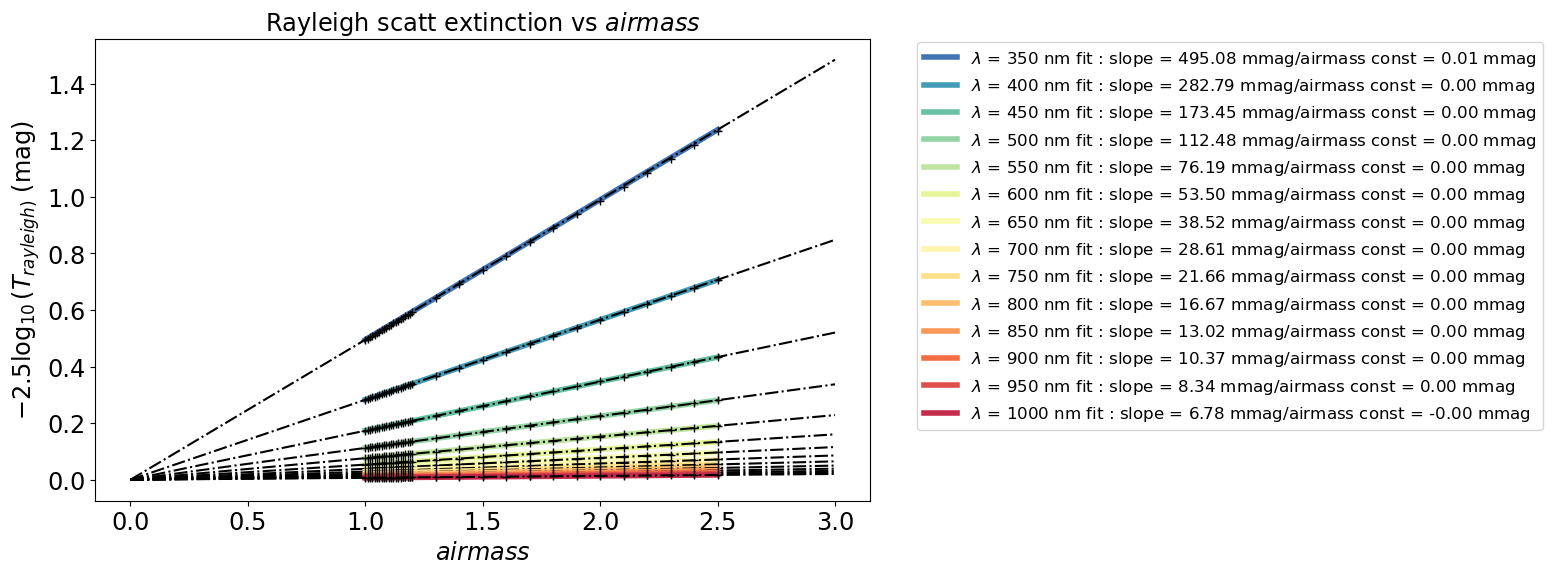

In [37]:
xfit = np.linspace(0.0,3.,100)

fig,ax = plt.subplots(1,1)

# compute a new transmission array in airmass x wl
transmarray = np.zeros((NAM,NWLtest))
    
for idx_am,airmass in enumerate(airmasses):
    transmarray[idx_am,:]  = emul.GetRayleighTransparencyArray(WLtest,airmass)

# plot attenuation 
for idx_wl,wl in enumerate(WLtest):
    x = airmasses
    y = -2.5*np.log10(transmarray[:,idx_wl])
    y_pyE = -2.5*np.log10(np.exp(-rayleigh_extinction[idx_wl]*x))

    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    gamma = z[0]*1000
    const = z[1]*1000
    
        
    bin_number_for_wl = np.digitize(wl,WLtest)-1
    the_wl_color = hls_colors[bin_number_for_wl]
    ls = linestyles[0]
    lw = linewidths[0]

    
    label = "$\\lambda$ = "+f"{wl:.0f} nm "+ f"fit : slope = {gamma:.2f} mmag/airmass const = {const:.2f} mmag"
    
    ax.plot(x,y,color=the_wl_color,ls = ls,lw=lw,label=label)
    ax.plot(xfit,p(xfit),'-.',color="k")
    ax.plot(x,y_pyE,color="k",lw=0,marker="+")
        
#ax.legend(loc='upper right')
ax.legend(bbox_to_anchor=(1.05, 1.01))
ax.set_xlabel("$airmass$")  
ax.set_ylabel("$-2.5\\log_{10}(T_{rayleigh)}$ (mag)")  
ax.set_title("Rayleigh scatt extinction vs $airmass$")

Text(0.5, 1.0, 'Rayleigh scatt extinction vs $airmass$')

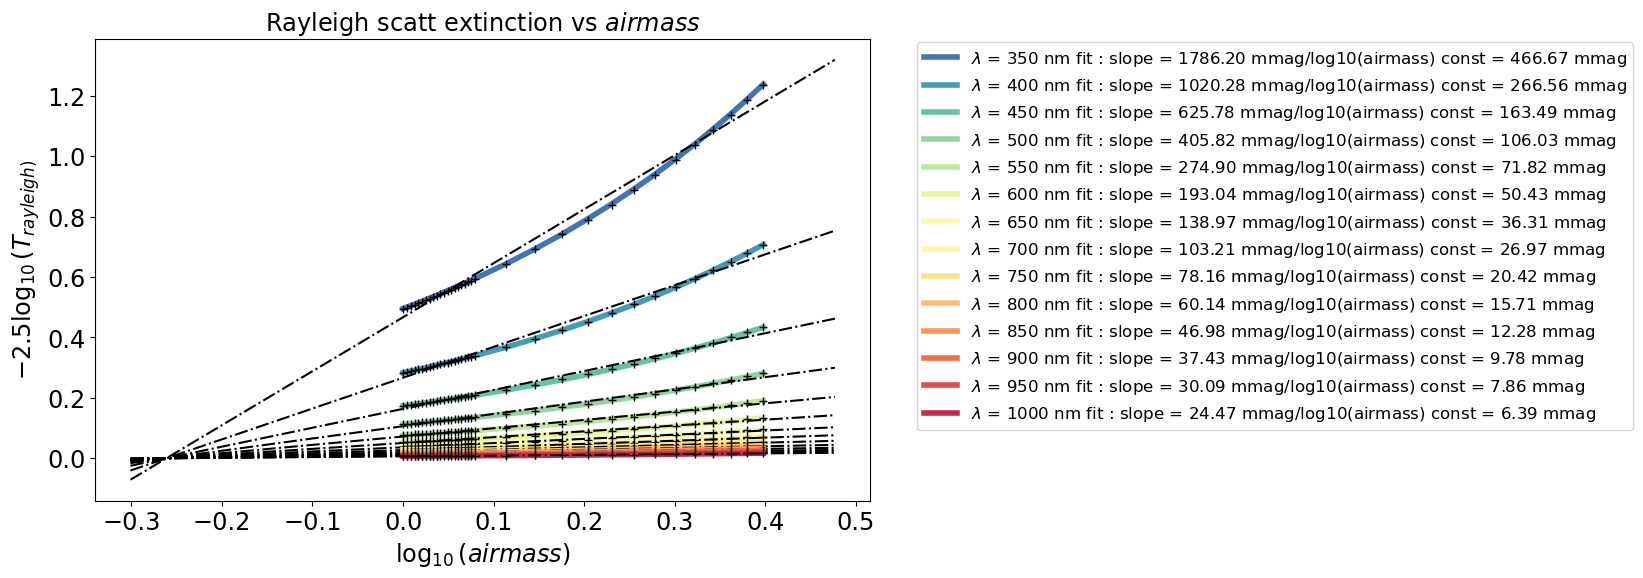

In [38]:
xfit = np.log10(np.linspace(0.5,3.,100))

fig,ax = plt.subplots(1,1)

# compute a new transmission array in airmass x wl
transmarray = np.zeros((NAM,NWLtest))
    
for idx_am,airmass in enumerate(airmasses):
    transmarray[idx_am,:]  = emul.GetRayleighTransparencyArray(WLtest,airmass)

# plot attenuation 
for idx_wl,wl in enumerate(WLtest):
    x = np.log10(airmasses)
    y = -2.5*np.log10(transmarray[:,idx_wl])
    y_pyE = -2.5*np.log10(np.exp(-rayleigh_extinction[idx_wl]*airmasses))

    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    gamma = z[0]*1000.
    const = z[1]*1000.
    
        
    bin_number_for_wl = np.digitize(wl,WLtest)-1
    the_wl_color = hls_colors[bin_number_for_wl]
    ls = linestyles[0]
    lw = linewidths[0]

    
    label = "$\\lambda$ = "+f"{wl:.0f} nm "+ f"fit : slope = {gamma:.2f} mmag/log10(airmass) const = {const:.2f} mmag"
    
    ax.plot(x,y,color=the_wl_color,ls = ls,lw=lw,label=label)
    ax.plot(xfit,p(xfit),'-.',color="k")
    ax.plot(x,y_pyE,color="k",lw=0,marker="+")
        
#ax.legend(loc='upper right')
ax.legend(bbox_to_anchor=(1.05, 1.01))
ax.set_xlabel("$\\log_{10}(airmass)$")  
ax.set_ylabel("$-2.5\\log_{10}(T_{rayleigh)}$")  
ax.set_title("Rayleigh scatt extinction vs $airmass$")

Text(0.5, 1.0, 'Rayleigh scatt extinction-ratio data/fit value vs $airmass$')

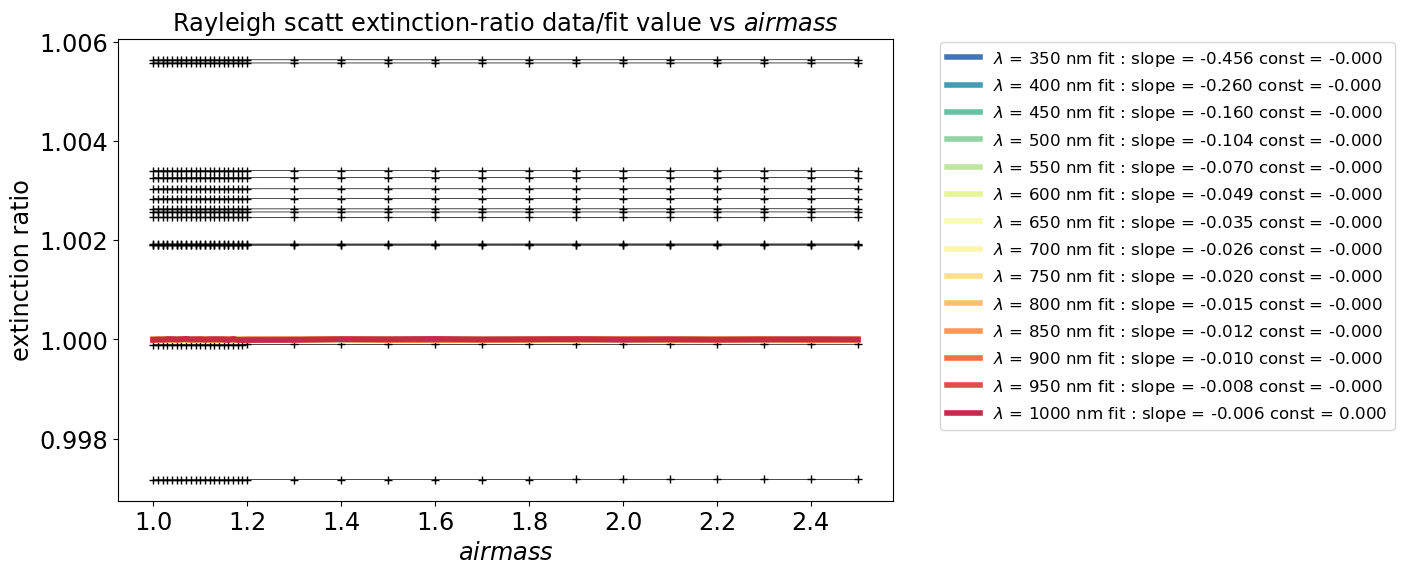

In [39]:
xfit = np.linspace(0.5,3.,100)

fig,ax = plt.subplots(1,1)

# compute a new transmission array in airmass x wl
transmarray = np.zeros((NAM,NWLtest))
    
for idx_am,airmass in enumerate(airmasses):
    transmarray[idx_am,:]  = emul.GetRayleighTransparencyArray(WLtest,airmass)

# plot attenuation 
for idx_wl,wl in enumerate(WLtest):
    x = airmasses
    y = np.log(transmarray[:,idx_wl])
    y_pyE = np.log(np.exp(-rayleigh_extinction[idx_wl]*x))

    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    gamma = z[0]
    const = z[1]
    
        
    bin_number_for_wl = np.digitize(wl,WLtest)-1
    the_wl_color = hls_colors[bin_number_for_wl]
    ls = linestyles[0]
    lw = linewidths[0]

    
    label = "$\\lambda$ = "+f"{wl:.0f} nm "+ f"fit : slope = {gamma:.3f} const = {const:.3f}"

    ratio_extinction = y/p(x)
    ratio_extinction_pyE = y_pyE/p(x)
    
    ax.plot(x,ratio_extinction,color=the_wl_color,ls = ls,lw=lw,label=label)
    ax.plot(x,ratio_extinction_pyE,color="k",lw=0.5,marker="+")
        
#ax.legend(loc='upper right')
ax.legend(bbox_to_anchor=(1.05, 1.01))
ax.set_xlabel("$airmass$")  
ax.set_ylabel("extinction ratio")  
ax.set_title("Rayleigh scatt extinction-ratio data/fit value vs $airmass$")

Text(0.5, 1.0, 'Rayleigh scatt extinction-ratio data/fit value vs $airmass$')

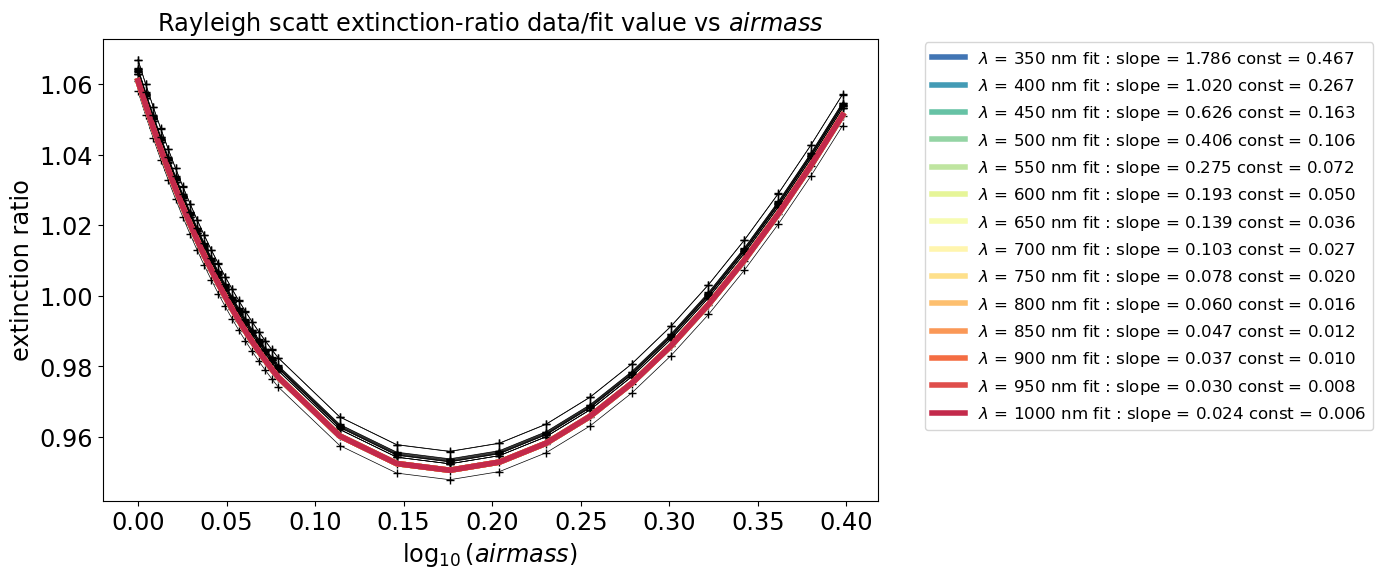

In [40]:
xfit = np.log10(np.linspace(0.5,3.,100))
fig,ax = plt.subplots(1,1)

# compute a new transmission array in airmass x wl
transmarray = np.zeros((NAM,NWLtest))
    
for idx_am,airmass in enumerate(airmasses):
    transmarray[idx_am,:]  = emul.GetRayleighTransparencyArray(WLtest,airmass)

# plot attenuation 
for idx_wl,wl in enumerate(WLtest):
    x = np.log10(airmasses)
    y = -2.5*np.log10(transmarray[:,idx_wl])
    y_pyE = -2.5*np.log10(np.exp(-rayleigh_extinction[idx_wl]*airmasses))

    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    gamma = z[0]
    const = z[1]
    
        
    bin_number_for_wl = np.digitize(wl,WLtest)-1
    the_wl_color = hls_colors[bin_number_for_wl]
    ls = linestyles[0]
    lw = linewidths[0]

    
    label = "$\\lambda$ = "+f"{wl:.0f} nm "+ f"fit : slope = {gamma:.3f} const = {const:.3f}"

    ratio_extinction = y/p(x)
    ratio_extinction_pyE = y_pyE/p(x)
    
    ax.plot(x,ratio_extinction,color=the_wl_color,ls = ls,lw=lw,label=label)
    ax.plot(x,ratio_extinction_pyE,color="k",lw=0.5,marker="+")
        
#ax.legend(loc='upper right')
ax.legend(bbox_to_anchor=(1.05, 1.01))
ax.set_xlabel("$\\log_{10}(airmass)$")  
ax.set_ylabel("extinction ratio")  
ax.set_title("Rayleigh scatt extinction-ratio data/fit value vs $airmass$")